In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import os


data_root = "/kaggle/input/impulse1/EEG_Data/train_data"
classes = ["Normal", "Electrographic_Seizures", "Complex_Partial_Seizures", "Video_detected_Seizures_with_no_visual_change_over_EEG"]

# Function to extract EEG data and labels
def load_eeg_data():
    X, y = [], []
    
    for cls_idx, cls in enumerate(classes):
        class_folder = os.path.join(data_root, cls)
        
        for file_name in os.listdir(class_folder):
            if file_name.endswith(".npy"):
                file_path = os.path.join(class_folder, file_name)
                eeg_signal = np.load(file_path)
                
                X.append(eeg_signal)
                y.append(cls_idx) 
    
    return np.array(X), np.array(y)

# Load EEG data
X, y = load_eeg_data()

# Reshape EEG Data for LSTM (batch, time_steps, features)
X = X.reshape(X.shape[0], -1, X.shape[1])  # (samples, time_steps, 19 channels)

# Split data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print final shapes
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")


X_train shape: (4473, 500, 19), X_val shape: (1119, 500, 19)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define LSTM Model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")  
])

# Compile Model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train LSTM Model
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.4672 - loss: 1.1270 - val_accuracy: 0.4978 - val_loss: 1.0044
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4818 - loss: 1.0214 - val_accuracy: 0.4978 - val_loss: 1.0067
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4913 - loss: 1.0300 - val_accuracy: 0.4978 - val_loss: 1.0032
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4918 - loss: 1.0053 - val_accuracy: 0.4978 - val_loss: 1.0020
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.4739 - loss: 1.0160 - val_accuracy: 0.4978 - val_loss: 1.0085
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5038 - loss: 1.0122 - val_accuracy: 0.4978 - val_loss: 1.0020
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5050 - loss: 1.0133 - val_accuracy: 0.4978 - val_loss: 1.0028
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5022 - loss: 0.9981 - val_accu

In [3]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
import numpy as np

# Predict on Validation Set
y_pred = np.argmax(lstm_model.predict(X_val), axis=1)

# Print Classification Report
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, lstm_model.predict(X_val), multi_class="ovr"))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.66       557
           1       0.00      0.00      0.00       106
           2       0.00      0.00      0.00       439
           3       0.00      0.00      0.00        17

    accuracy                           0.50      1119
   macro avg       0.12      0.25      0.17      1119
weighted avg       0.25      0.50      0.33      1119

Balanced Accuracy Score: 0.25
 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
ROC AUC Score: 0.49050487836963896


In [4]:
from tensorflow.keras.layers import Bidirectional, BatchNormalization

# Define Improved LSTM Model
lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    BatchNormalization(),  # Normalize activations
    LSTM(32),
    BatchNormalization(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")  
])

# Compile Model
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train Model with More Epochs
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.4229 - loss: 1.2718 - val_accuracy: 0.4978 - val_loss: 1.2821
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6022 - loss: 0.9846 - val_accuracy: 0.4978 - val_loss: 1.2178
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6301 - loss: 0.9213 - val_accuracy: 0.4978 - val_loss: 1.1547
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6666 - loss: 0.8669 - val_accuracy: 0.5067 - val_loss: 1.1502
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6805 - loss: 0.8407 - val_accuracy: 0.5121 - val_loss: 1.1346
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6949 - loss: 0.8216 - val_accuracy: 0.5451 - val_loss: 1.1061
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7057 - loss: 0.7870 - val_accuracy: 0.5728 - val_loss: 1.0380
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.7163 - loss: 0.7541 - val_accuracy: 0.3735 - v

In [5]:
# Predict on Validation Set
y_pred = np.argmax(lstm_model.predict(X_val), axis=1)

#Performance Metrics
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, lstm_model.predict(X_val), multi_class="ovr"))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Balanced Accuracy Score: 0.5474883696529677
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
ROC AUC Score: 0.833449510289598


In [6]:
# Paths to noisy and clean EEG data
noisy_data_path = "/kaggle/input/impulse1/EEG_Data/noisy_train_data"
clean_data_path = "/kaggle/input/impulse1/EEG_Data/train_data"

def load_eeg_pairs():
    """
    Load corresponding noisy and clean EEG signals for training Autoencoder.
    Skips missing files.
    """
    X_noisy, X_clean = [], []
    
    for cls in classes:  
        noisy_class_folder = os.path.join(noisy_data_path, cls)
        clean_class_folder = os.path.join(clean_data_path, cls)
        
        for file_name in os.listdir(noisy_class_folder):
            if file_name.endswith(".npy"):
                noisy_file = os.path.join(noisy_class_folder, file_name)
                clean_file = os.path.join(clean_class_folder, file_name)

                # Skip missing files
                if not os.path.exists(clean_file):
                    print(f"Skipping missing file: {clean_file}")
                    continue
                
                try:
                    # Load noisy and clean EEG signals
                    noisy_signal = np.load(noisy_file)
                    clean_signal = np.load(clean_file)
                    
                    X_noisy.append(noisy_signal)
                    X_clean.append(clean_signal)

                except Exception as e:
                    print(f"Error loading {file_name}: {e}")

    return np.array(X_noisy), np.array(X_clean)

# Load data
X_noisy, X_clean = load_eeg_pairs()

# Reshape for LSTM Autoencoder 
X_noisy = X_noisy.reshape(X_noisy.shape[0], -1, X_noisy.shape[1])
X_clean = X_clean.reshape(X_clean.shape[0], -1, X_clean.shape[1])


print(f"Noisy Data Shape: {X_noisy.shape}, Clean Data Shape: {X_clean.shape}")


Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/7009.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6921.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6907.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6916.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6855.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6883.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6962.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/7002.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6838.npy
Skipping missing file: /kaggle/input/impulse1/EEG_Data/train_data/Electrographic_Seizures/6956.npy
Skipping m

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

# Define LSTM Autoencoder
autoencoder = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_noisy.shape[1], X_noisy.shape[2])),
    LSTM(32, return_sequences=True),
    TimeDistributed(Dense(X_noisy.shape[2]))  
])

# Compile Model
autoencoder.compile(optimizer="adam", loss="mse")  

# Train Autoencoder
autoencoder.fit(X_noisy, X_clean, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - loss: 4.2011e-04 - val_loss: 3.1362e-04
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 1.7358e-04 - val_loss: 2.4141e-04
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 1.3237e-04 - val_loss: 2.2281e-04
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 1.2746e-04 - val_loss: 2.0599e-04
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 1.0944e-04 - val_loss: 1.8536e-04
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 1.0148e-04 - val_loss: 1.6083e-04
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 9.2036e-05 - val_loss: 1.5989e-04
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 9.0132e-05 - val_loss: 1.5229e-04
Epoch 9/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 8.2758e-05 - val_loss: 1.4710e-04
Epoch 10/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 8.0391e-05 - val_loss: 1.4187e-04
Epoch 11/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


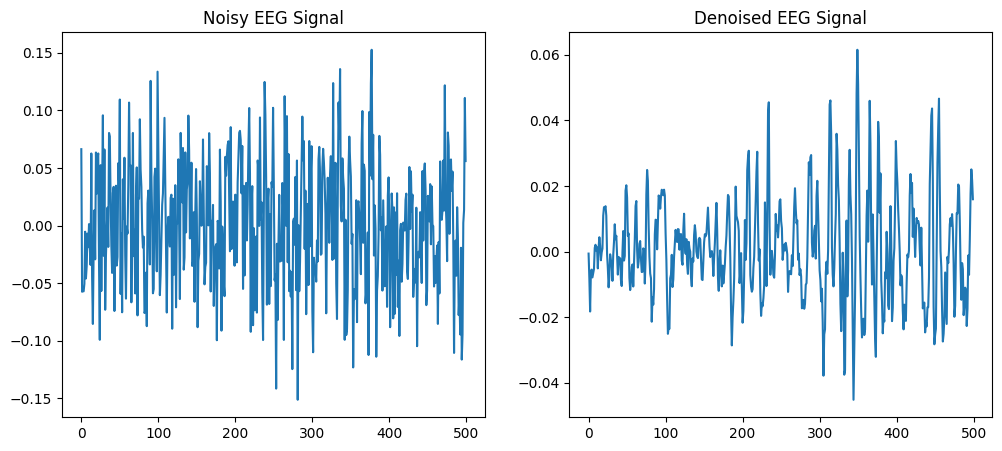

In [12]:
import matplotlib.pyplot as plt

# Pick a random noisy EEG sample
sample_idx = np.random.randint(0, len(X_noisy))
noisy_sample = X_noisy[sample_idx:sample_idx+1]

# Get the Autoencoder's prediction 
denoised_sample = autoencoder.predict(noisy_sample)[0]

# Plot comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(noisy_sample[0, :, 0])  
plt.title("Noisy EEG Signal")

plt.subplot(1, 2, 2)
plt.plot(denoised_sample[:, 0])  
plt.title("Denoised EEG Signal")

plt.show()


In [ ]:
denoised_data_path = "/kaggle/working/denoised_train_data1"
os.makedirs(denoised_data_path, exist_ok=True)

for cls in classes:
    cls_output_folder = os.path.join(denoised_data_path, cls)
    os.makedirs(cls_output_folder, exist_ok=True)
    
    noisy_class_folder = os.path.join(noisy_data_path, cls)
    for file_name in os.listdir(noisy_class_folder):
        if file_name.endswith(".npy"):
            noisy_file = os.path.join(noisy_class_folder, file_name)
            noisy_signal = np.load(noisy_file)
            noisy_signal = noisy_signal.reshape(1, -1, noisy_signal.shape[0])  
            
            # Denoise the signal
            denoised_signal = autoencoder.predict(noisy_signal)[0]
            
            np.save(os.path.join(cls_output_folder, file_name), denoised_signal)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

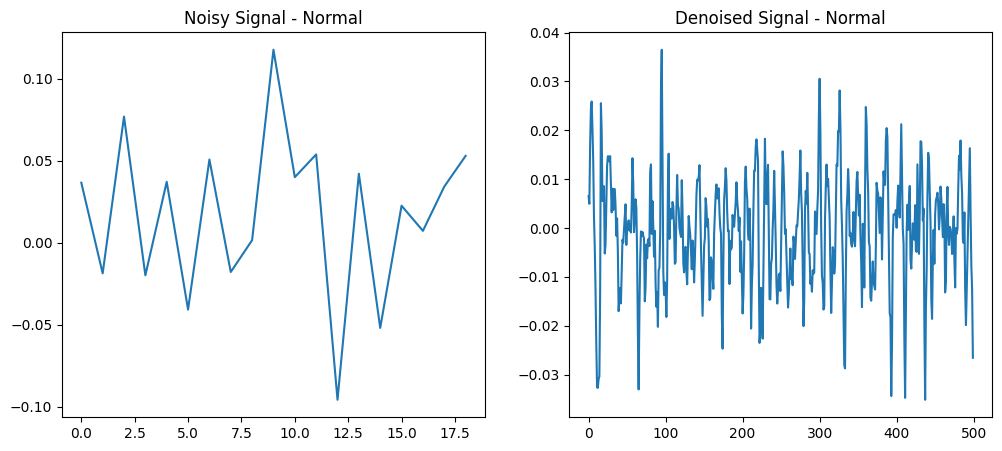

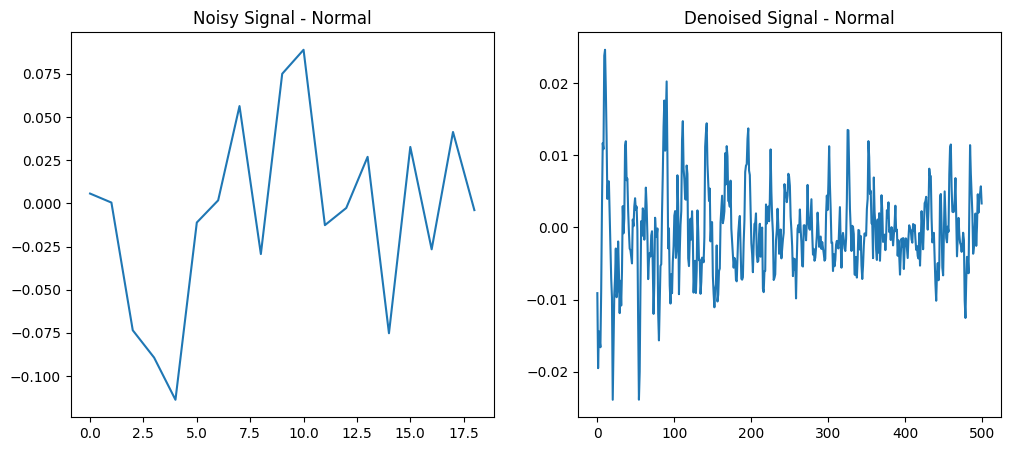

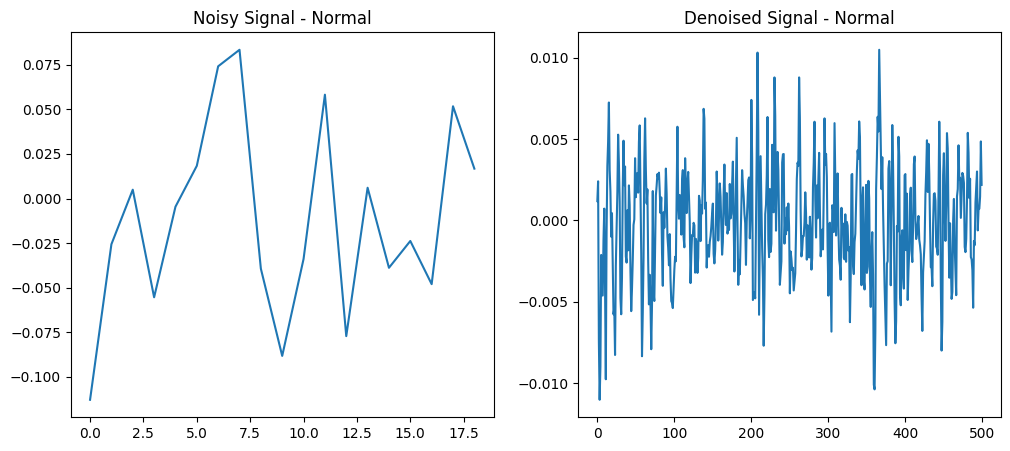

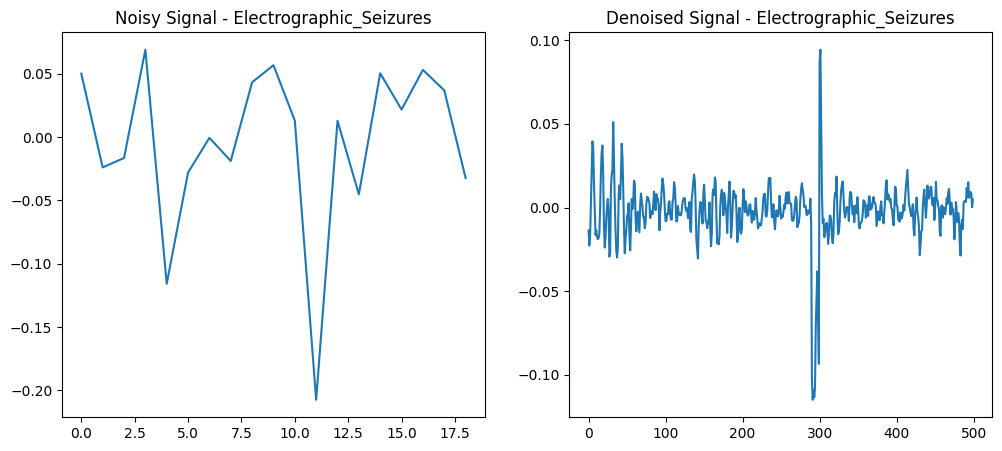

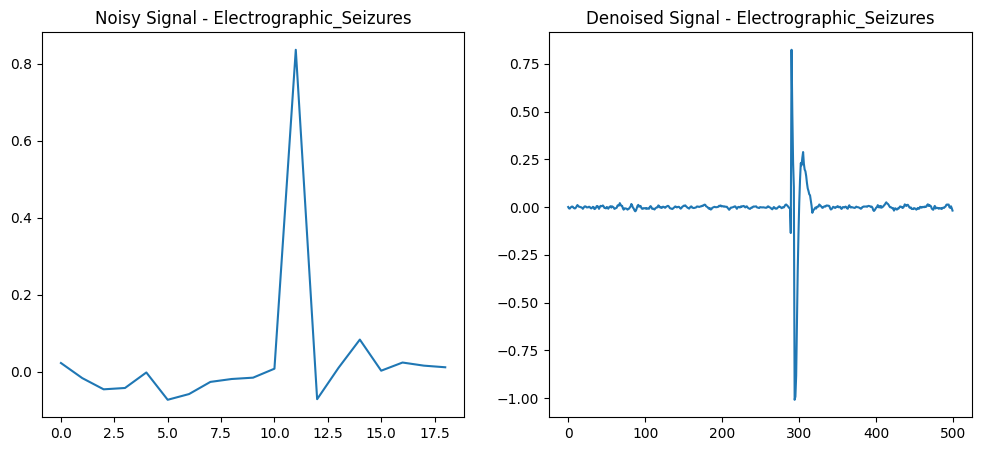

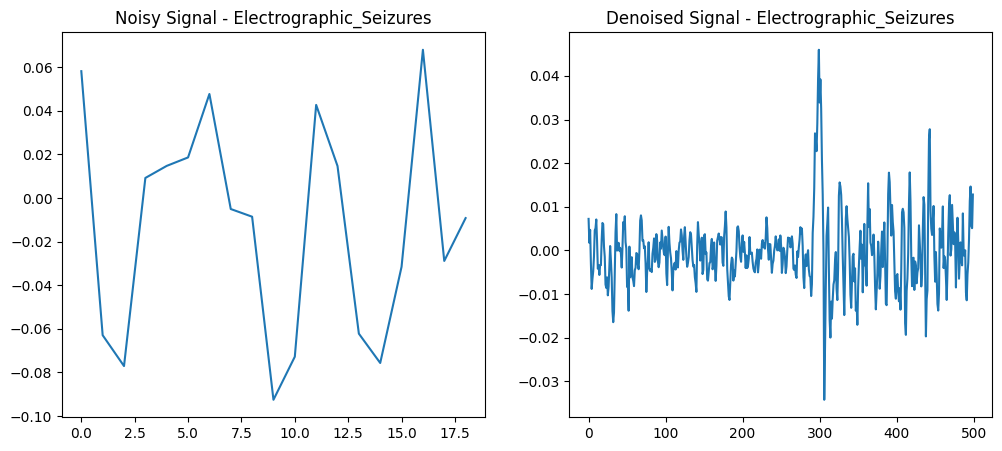

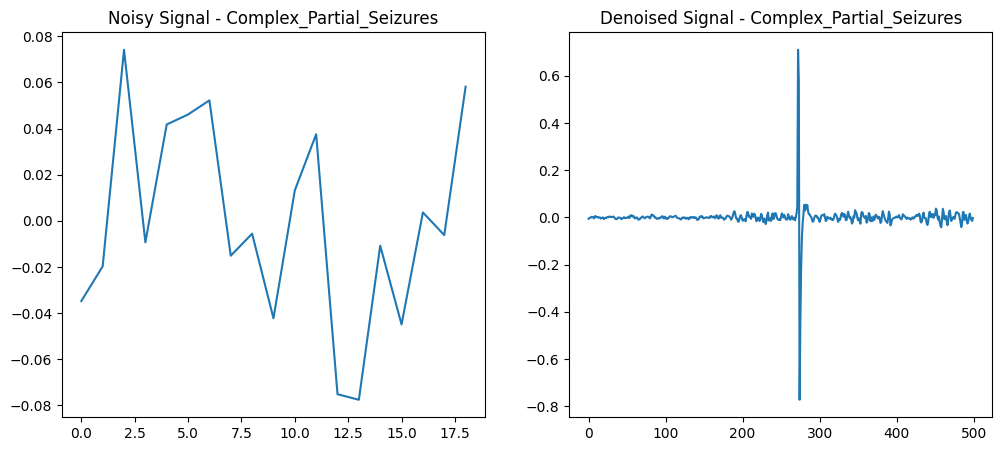

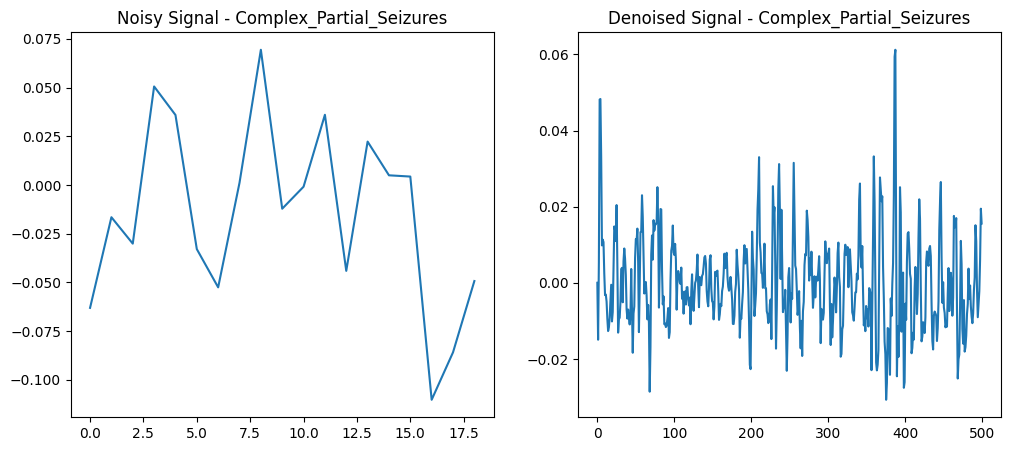

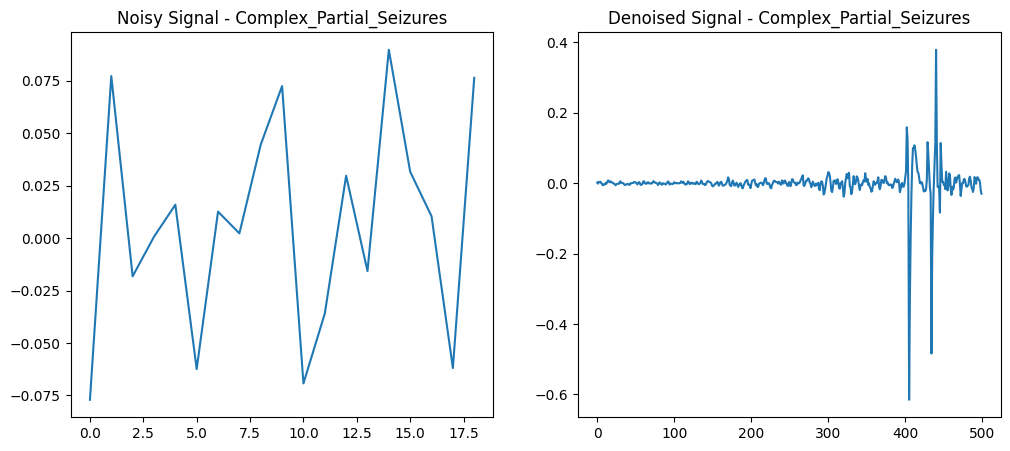

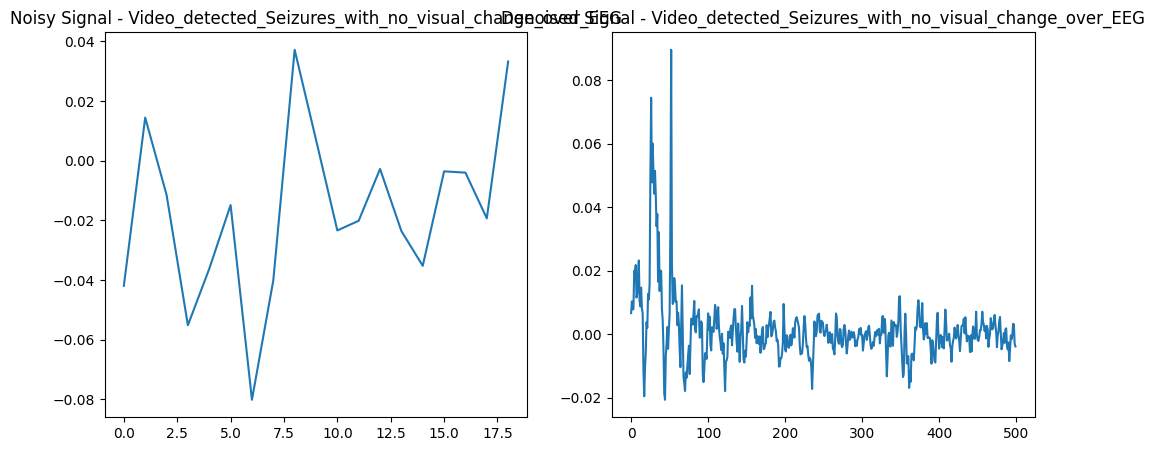

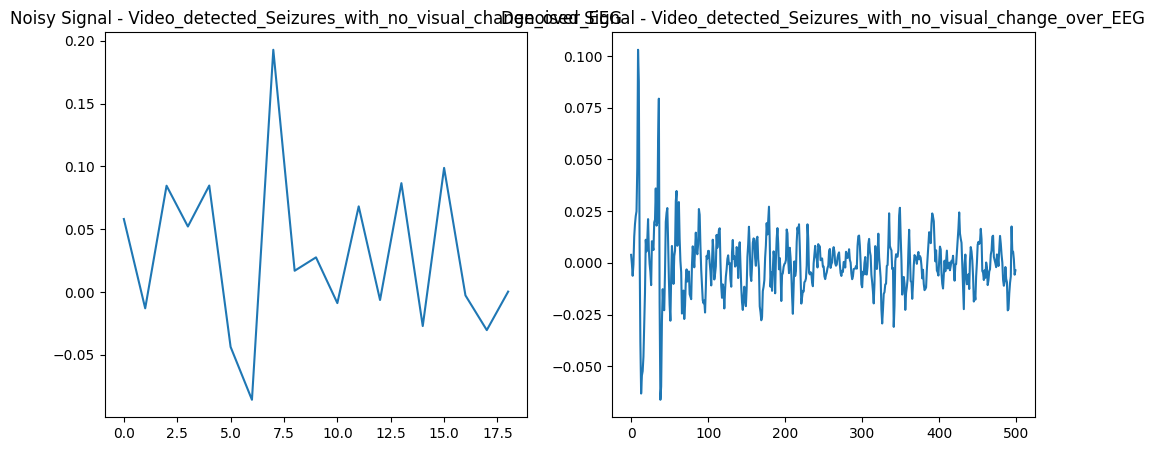

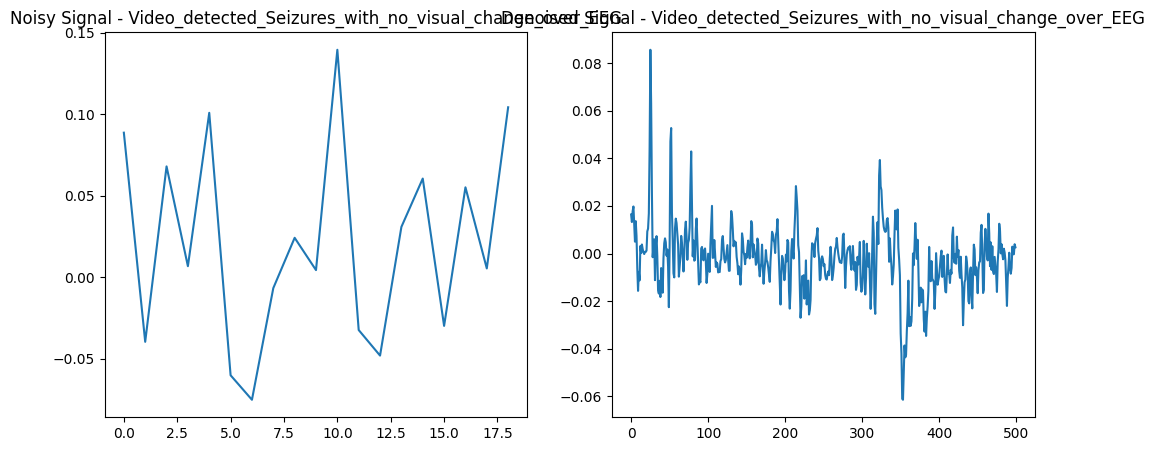

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4937 - loss: 1.1476 - val_accuracy: 0.6417 - val_loss: 0.8996
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6190 - loss: 0.9078 - val_accuracy: 0.6551 - val_loss: 0.8514
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6513 - loss: 0.8582 - val_accuracy: 0.6827 - val_loss: 0.8176
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6746 - loss: 0.8275 - val_accuracy: 0.6943 - val_loss: 0.7931
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6880 - loss: 0.7810 - val_accuracy: 0.7014 - val_loss: 0.7825
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7054 - loss: 0.7617 - val_accuracy: 0.7059 - val_loss: 0.7562
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7204 - loss: 0.7141 - val_accuracy: 0.7246 - val_loss: 0.7340
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7375 - loss: 0.6971 - val_accuracy: 0.

In [35]:
# Visualize noisy vs. denoised signals
for cls in classes:
    noisy_class_folder = os.path.join(noisy_data_path, cls)
    for file_name in os.listdir(noisy_class_folder)[:3]:  
        noisy_file = os.path.join(noisy_class_folder, file_name)
        denoised_file = os.path.join(denoised_data_path, cls, file_name)
        
        noisy_signal = np.load(noisy_file)
        denoised_signal = np.load(denoised_file)
        
       
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(noisy_signal[:, 0])  
        plt.title(f"Noisy Signal - {cls}")
        plt.subplot(1, 2, 2)
        plt.plot(denoised_signal[:, 0])  
        plt.title(f"Denoised Signal - {cls}")
        plt.show()


# Reload denoised data
def load_denoised_data():
    X, y = [], []
    for cls_idx, cls in enumerate(classes):
        class_folder = os.path.join(denoised_data_path, cls)
        for file_name in os.listdir(class_folder):
            if file_name.endswith(".npy"):
                file_path = os.path.join(class_folder, file_name)
                denoised_signal = np.load(file_path)
                X.append(denoised_signal)
                y.append(cls_idx)  
    return np.array(X), np.array(y)


X_denoised, y_denoised = load_denoised_data()

# Reshape for LSTM
X_denoised = X_denoised.reshape(X_denoised.shape[0], -1, X_denoised.shape[1])  

# Split data into train and validation
X_train_denoised, X_val_denoised, y_train_denoised, y_val_denoised = train_test_split(
    X_denoised, y_denoised, test_size=0.2, random_state=42, stratify=y_denoised
)

# train the LSTM model on denoised data
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_denoised.shape[1], X_train_denoised.shape[2])),
    LSTM(32),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax")  
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train the model
lstm_model.fit(X_train_denoised, y_train_denoised, validation_data=(X_val_denoised, y_val_denoised), epochs=20, batch_size=32)

# Evaluate the model
y_pred_denoised = np.argmax(lstm_model.predict(X_val_denoised), axis=1)
print("Classification Report:\n", classification_report(y_val_denoised, y_pred_denoised))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val_denoised, y_pred_denoised))
print("ROC AUC Score:", roc_auc_score(y_val_denoised, lstm_model.predict(X_val_denoised), multi_class="ovr"))


In [16]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, BatchNormalization

lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train_denoised.shape[1], X_train_denoised.shape[2]))),
    BatchNormalization(),
    LSTM(32),
    BatchNormalization(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="softmax") 
])

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
lstm_model.fit(
    X_train_denoised, y_train_denoised,
    validation_data=(X_val_denoised, y_val_denoised),
    epochs=30, batch_size=32,
    callbacks=[lr_scheduler]
)

y_pred_denoised = np.argmax(lstm_model.predict(X_val_denoised), axis=1)
print("Classification Report:\n", classification_report(y_val_denoised, y_pred_denoised))
print("Balanced Accuracy Score:", balanced_accuracy_score(y_val_denoised, y_pred_denoised))
print("ROC AUC Score:", roc_auc_score(y_val_denoised, lstm_model.predict(X_val_denoised), multi_class="ovr"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5465 - loss: 1.1276 - val_accuracy: 0.3913 - val_loss: 1.2238 - learning_rate: 0.0010
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6864 - loss: 0.8424 - val_accuracy: 0.3904 - val_loss: 1.0650 - learning_rate: 0.0010
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6952 - loss: 0.8065 - val_accuracy: 0.6809 - val_loss: 0.8450 - learning_rate: 0.0010
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7010 - loss: 0.7945 - val_accuracy: 0.7005 - val_loss: 0.7897 - learning_rate: 0.0010
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7218 - loss: 0.7324 - val_accuracy: 0.7246 - val_loss: 0.7554 - learning_rate: 0.0010
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7330 - loss: 0.7340 - val_accuracy: 0.7210 - val_loss: 0.7489 - learning_rate: 0.0010
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7340 - loss: 0.68

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ROC AUC Score: 0.8535006952528047


In [17]:
from scipy.fft import fft
import pywt

def extract_features(data):
    features = []
    for signal in data:
        signal_features = []
        for channel in signal.T:  # Iterate over channels
            # Time-domain features
            mean = np.mean(channel)
            variance = np.var(channel)
            rms = np.sqrt(np.mean(channel**2))

            # Frequency-domain features (FFT)
            freq_components = np.abs(fft(channel))[:len(channel)//2]
            spectral_energy = np.sum(freq_components**2)

            # Wavelet decomposition 
            coeffs = pywt.wavedec(channel, 'db4', level=4)
            approx_energy = np.sum(coeffs[0]**2)
            detail_energy = [np.sum(c**2) for c in coeffs[1:]]

            signal_features.extend([mean, variance, rms, spectral_energy, approx_energy, *detail_energy])
        features.append(signal_features)
    return np.array(features)

# Extract features for training and validation sets
X_train_features = extract_features(X_train_denoised)
X_val_features = extract_features(X_val_denoised)

print(f"Feature Matrix Shape: {X_train_features.shape}")


/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Feature Matrix Shape: (4486, 4500)


In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

# Train SVM
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train_denoised)

# Evaluate SVM
y_pred_svm = svm_model.predict(X_val_scaled)
print("SVM Classification Report:\n", classification_report(y_val_denoised, y_pred_svm))
print("Balanced Accuracy Score (SVM):", balanced_accuracy_score(y_val_denoised, y_pred_svm))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.92      0.78       557
           1       0.00      0.00      0.00       109
           2       0.80      0.65      0.71       439
           3       0.00      0.00      0.00        17

    accuracy                           0.71      1122
   macro avg       0.37      0.39      0.37      1122
weighted avg       0.64      0.71      0.67      1122

Balanced Accuracy Score (SVM): 0.3924313868225075


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_denoised)

# Retrain SVM on balanced data
svm_model_balanced = SVC(kernel="rbf", probability=True, random_state=42)
svm_model_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluate the retrained SVM
y_pred_svm_balanced = svm_model_balanced.predict(X_val_scaled)
print("SVM Classification Report After Balancing:\n", classification_report(y_val_denoised, y_pred_svm_balanced))
print("Balanced Accuracy Score (SVM After Balancing):", balanced_accuracy_score(y_val_denoised, y_pred_svm_balanced))


SVM Classification Report After Balancing:
               precision    recall  f1-score   support

           0       0.74      0.64      0.69       557
           1       0.16      0.34      0.22       109
           2       0.82      0.62      0.71       439
           3       0.03      0.12      0.05        17

    accuracy                           0.60      1122
   macro avg       0.44      0.43      0.41      1122
weighted avg       0.70      0.60      0.64      1122

Balanced Accuracy Score (SVM After Balancing): 0.43030270357818295


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_train_balanced, y_train_balanced)

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_val_scaled)
print("Random Forest Classification Report:\n", classification_report(y_val_denoised, y_pred_rf))
print("Balanced Accuracy Score (Random Forest):", balanced_accuracy_score(y_val_denoised, y_pred_rf))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75       557
           1       0.25      0.25      0.25       109
           2       0.78      0.74      0.76       439
           3       0.50      0.06      0.11        17

    accuracy                           0.70      1122
   macro avg       0.56      0.45      0.46      1122
weighted avg       0.69      0.70      0.69      1122

Balanced Accuracy Score (Random Forest): 0.45357146701286344


In [21]:
# Train Random Forest on noisy data for comparison
rf_model_noisy = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_noisy.fit(X_train_scaled, y_train_denoised)

# Evaluate Random Forest trained on noisy data
y_pred_rf_noisy = rf_model_noisy.predict(X_val_scaled)
print("Random Forest (Noisy Data) Classification Report:\n", classification_report(y_val_denoised, y_pred_rf_noisy))
print("Balanced Accuracy Score (Noisy):", balanced_accuracy_score(y_val_denoised, y_pred_rf_noisy))


Random Forest (Noisy Data) Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.91      0.80       557
           1       0.50      0.02      0.04       109
           2       0.81      0.73      0.76       439
           3       0.00      0.00      0.00        17

    accuracy                           0.74      1122
   macro avg       0.50      0.41      0.40      1122
weighted avg       0.71      0.74      0.70      1122

Balanced Accuracy Score (Noisy): 0.41470604048541315


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import pandas as pd
test_data_path = "/kaggle/input/impulse1/EEG_Data/test_data"

# Load test data
def load_test_data(test_data_path):
    X_test = []
    test_files = []
    
    for file_name in os.listdir(test_data_path):
        if file_name.endswith(".npy"):
            file_path = os.path.join(test_data_path, file_name)
            test_signal = np.load(file_path)
            X_test.append(test_signal)
            test_files.append(file_name) 
    
    return np.array(X_test), test_files

X_test, test_files = load_test_data(test_data_path)

# Reshape test data for LSTM 
X_test = X_test.reshape(X_test.shape[0], -1, X_test.shape[1])

# Predict test labels
y_test_pred = np.argmax(lstm_model.predict(X_test), axis=1)

# Map predictions 
label_to_class = {
    0: "Normal",
    1: "Complex Partial Seizures",
    2: "Electrographic Seizures",
    3: "Video detected Seizures with no visual change over EEG"
}


test_outputs = pd.DataFrame({
    "File": test_files,
    "Prediction": [label_to_class[label] for label in y_test_pred]
})

# CCSV
test_outputs.to_csv("test_outputs.csv", index=False)
print("Test outputs saved to test_outputs.csv!")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Test outputs saved to test_outputs.csv!
